#### Peer-graded Assignment: Анализ данных в задаче кредитного скоринга

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

    LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
    SEX: пол клиента (1 = мужской, 2 = женский )
    EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
    MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
    AGE: возраст в годах
    PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
    BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
    PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
    default - индикатор невозврата денежных средств

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("credit_card_default_analysis.csv", header = 0)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


#### Задание 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [3]:
LB0 = df[df.default == 0.0].LIMIT_BAL.values # Кредитный лимит вернувших кредит

In [4]:
LB1 = df[df.default == 1.0].LIMIT_BAL.values # Кредитный лимит невернувших кредит

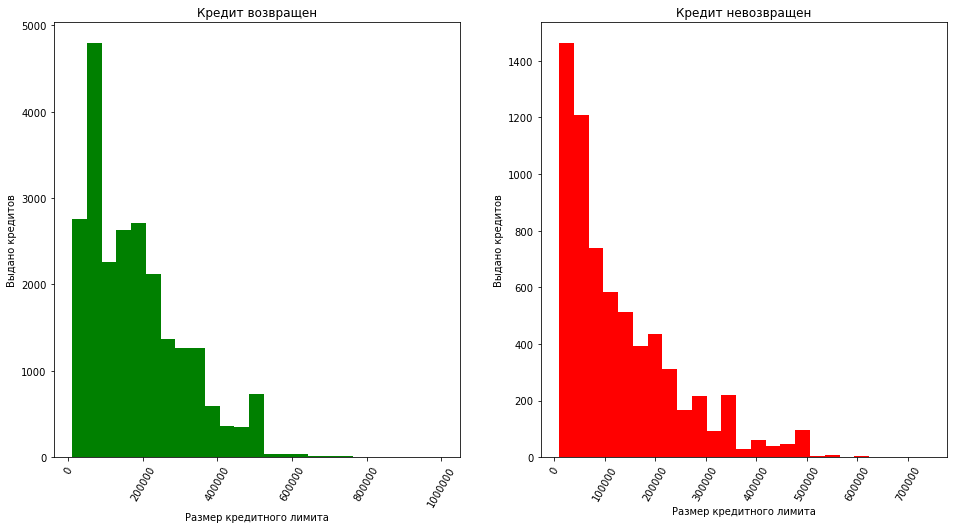

In [11]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
for txt in plt.gca().xaxis.get_majorticklabels():
    txt.set_rotation(60)
plt.hist(LB0, bins = 25, color = 'g')
plt.xlabel(u'Размер кредитного лимита')
plt.ylabel(u'Выдано кредитов')
plt.title(u'Кредит возвращен')

plt.subplot(1,2,2)
for txt in plt.gca().xaxis.get_majorticklabels():
    txt.set_rotation(60)
plt.hist(LB1, bins = 25, color = 'r')
plt.xlabel(u'Размер кредитного лимита')
plt.ylabel(u'Выдано кредитов')
plt.title(u'Кредит невозвращен')

plt.show()

Распределение нам не известно. Построим доверительные интервалы на основе bootstrap. 

In [32]:
def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [43]:
LB0_median = map(np.median, get_bootstrap_samples(LB0, 1000))
LB1_median  = map(np.median, get_bootstrap_samples(LB1, 1000))

In [44]:
print "95% доверительный интервал для медианных значений кредитного лимита вернувших кредит", stat_intervals(LB0_median, 0.05)
print "95% доверительный интервал для медианных значений кредитного лимита невернувших кредит", stat_intervals(LB1_median, 0.05)

95% доверительный интервал для медианных значений кредитного лимита вернувших кредит [ 150000.  150000.]
95% доверительный интервал для медианных значений кредитного лимита невернувших кредит [ 80000.  90000.]


Интервалы не пересекаются, гипотеза о равенстве медианных значений отвергается. Проверим гипотезу о равенстве распределений с помощью перестановочного критерия проверки равенства средних.

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [35]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [36]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [37]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [38]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [77]:
print "p-value: %f" % permutation_test(LB0, LB1, max_permutations = 2500)

p-value: 0.000400


#### Вывод.
Гипотеза о равенстве распределений отвергается. Признак значим для построения модели.  

#### Задание 2
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается.


In [12]:
SEX0 = list(df[df.default == 0.0].SEX) # Пол вернувших кредит

In [13]:
SEX1 = list(df[df.default == 1.0].SEX) # Пол невернувших кредит

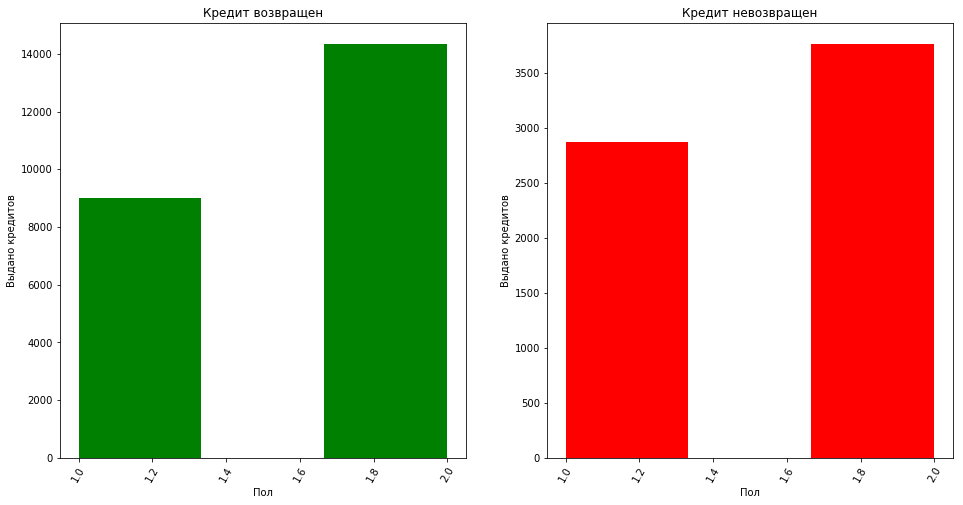

In [16]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
for txt in plt.gca().xaxis.get_majorticklabels():
    txt.set_rotation(60)
plt.hist(SEX0, bins = 3, color = 'g')
plt.xlabel(u'Пол')
plt.ylabel(u'Выдано кредитов')
plt.title(u'Кредит возвращен')

plt.subplot(1,2,2)
for txt in plt.gca().xaxis.get_majorticklabels():
    txt.set_rotation(60)
plt.hist(SEX1, bins = 3, color = 'r')
plt.xlabel(u'Пол')
plt.ylabel(u'Выдано кредитов')
plt.title(u'Кредит невозвращен')

plt.show()

Применяем Z-критерий для разности долей (независимые выборки).

#### Z-критерий для разности долей (независимые выборки)

| $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [22]:
S0 = [1] * SEX0.count(1) + [0] * SEX0.count(2) # 1-мужчины 0-женщины

In [27]:
S1 = [1] * SEX1.count(1) + [0] * SEX1.count(2)

In [23]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [24]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [25]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [28]:
z_stat = proportions_diff_z_stat_ind(S0, S1)

In [33]:
print "95%% доверительный интервал разницы долей между мужчинами и женщинами (Индикатор 0/Индикатор 1)]"
proportions_diff_confint_ind(S0, S1)  


95%% доверительный интервал разницы долей между мужчинами и женщинами (Индикатор 0/Индикатор 1)]


(-0.060548077974896725, -0.033634932749628671)

In [34]:
print "p-value: ", proportions_diff_z_test(z_stat)

p-value:  4.47286652161e-12


### Вывод:
 гипотеза о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается, отвергается на уовне значимости 0.05. Признак незначим для построения модели.

### Задача 3
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ? 

In [4]:
ED0 = df[df.default == 0.0].EDUCATION

In [5]:
ED1 = df[df.default == 1.0].EDUCATION

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


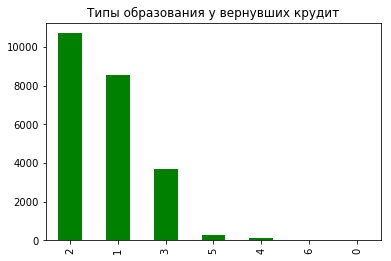

In [45]:
ED0.value_counts().plot(kind='bar', title=u'Типы образования у вернувших крудит', color = 'g')

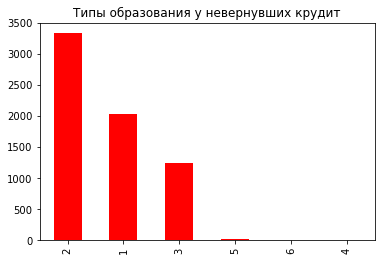

In [47]:
ED1.value_counts().plot(kind='bar', title=u'Типы образования у невернувших крудит', color = 'r')

#### Имеем 2 категориальных признака (два значения у default и 7 значений у EDUCATION). 

Построим таблицу сопряженности:

In [60]:
Contingency = pd.DataFrame({u'Вернули кредит': ED0.value_counts(),
                            u'Не вернули кредит': ED1.value_counts()})
Contingency

,Вернули кредит,Не вернули кредит
0,14,NaN
1,8549,2036.0
2,10700,3330.0
3,3680,1237.0
4,116,7.0
5,262,18.0
6,43,8.0


#### Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ? 

Составим таблицу отношения вернувших кредит к невернувшим по типам образования. Чем больше отношение - тем больше уверенность, что человек с таким образованием вернет кредит.

In [49]:
Ratio = ED0.value_counts()/ED1.value_counts()


In [50]:
Ratio

0          NaN
1     4.198919
2     3.213213
3     2.974939
4    16.571429
5    14.555556
6     5.375000
Name: EDUCATION, dtype: float64

Исходя из их определения,типы образований 5 и 6 не имеет смысла рассматривать. По образованию тип 0 - нет данных.  

#### Провеним гипотезу о независимости данных в таблице сопряженности 

Уберем из таблицы сопряженности неопределенные значения, а также тип образование 6 ("нет данных") 

In [61]:
Contingency.drop(Contingency.index[[0,6]], inplace = True )
Contingency

,Вернули кредит,Не вернули кредит
1,8549,2036.0
2,10700,3330.0
3,3680,1237.0
4,116,7.0
5,262,18.0


In [62]:
stats.chi2_contingency(Contingency)

(157.8980281928655,
 4.1275461591669116e-33,
 4,
 array([[  8241.34274261,   2343.65725739],
        [ 10923.57474528,   3106.42525472],
        [  3828.31197595,   1088.68802405],
        [    95.76619342,     27.23380658],
        [   218.00434274,     61.99565726]]))

#### Вывод
p-value: 1.2332626245415605e-32. Гипотеза о том, что образование не влияет на возврат долга отвергается. Признак значим для построения модели.

#### Задание 4
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

#### Аналогично заданию 3 построим таблицу сопряженности и проверим гипотезу о независмости в ней данных

In [11]:
set(df.MARRIAGE)

{0, 1, 2, 3}

In [12]:
M0 = df[df.default == 0.0].MARRIAGE

In [13]:
M1 = df[df.default == 1.0].MARRIAGE

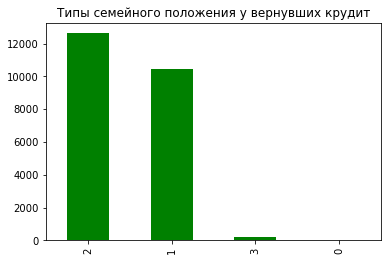

In [16]:
M0.value_counts().plot(kind='bar', title=u'Типы семейного положения у вернувших крудит', color = 'g')

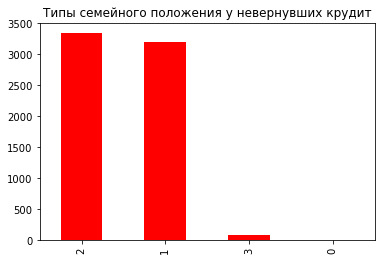

In [18]:
M1.value_counts().plot(kind='bar', title=u'Типы семейного положения у невернувших крудит', color = 'r')

In [22]:
Contingency1 = pd.DataFrame({u'Вернули кредит': M0.value_counts(),
                            u'Не вернули кредит': M1.value_counts()})

In [23]:
Contingency1

,Вернули кредит,Не вернули кредит
2,12623,3341
1,10453,3206
3,239,84
0,49,5


#### Оставим значения: 1 = замужем/женат; 2 = холост. По другим значениям нельзя сделать вывод.

In [26]:
Contingency1.drop(Contingency1.index[[2,3]], inplace = True )

In [28]:
Contingency1

,Вернули кредит,Не вернули кредит
2,12623,3341
1,10453,3206


In [27]:
stats.chi2_contingency(Contingency1)

(27.509409092957899,
 1.5633210355976673e-07,
 1,
 array([[ 12435.78516693,   3528.21483307],
        [ 10640.21483307,   3018.78516693]]))

#### Вывод

p-value: 1.5633210355976673e-07. Гипотеза о том, что семейное положение не влияет на возврат долга отвергается. Признак значим для построения модели.


#### Задание 5
Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

#### Выполним по аналогии с пунктом 1.

In [29]:
AGE0 = df[df.default == 0.0].AGE.values 

In [30]:
AGE1 = df[df.default == 1.0].AGE.values 

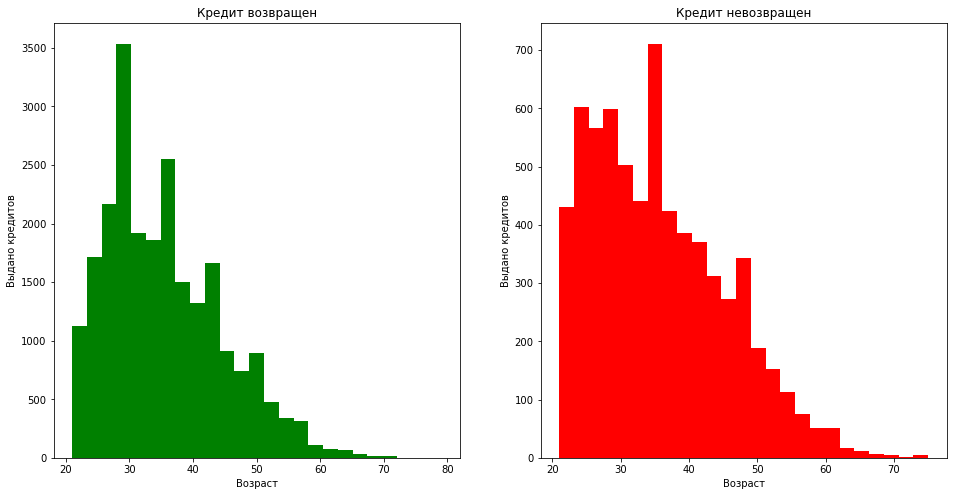

In [31]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.hist(AGE0, bins = 25, color = 'g')
plt.xlabel(u'Возраст')
plt.ylabel(u'Выдано кредитов')
plt.title(u'Кредит возвращен')

plt.subplot(1,2,2)
plt.hist(AGE1, bins = 25, color = 'r')
plt.xlabel(u'Возраст')
plt.ylabel(u'Выдано кредитов')
plt.title(u'Кредит невозвращен')

plt.show()

In [33]:
AGE0_median = map(np.median, get_bootstrap_samples(AGE0, 1000))
AGE1_median  = map(np.median, get_bootstrap_samples(AGE1, 1000))

In [34]:
print "95% доверительный интервал для медианных значений возраста вернувших кредит", stat_intervals(AGE0_median, 0.05)
print "95% доверительный интервал для медианных значений кредитного лимита невернувших кредит", stat_intervals(AGE1_median, 0.05)

95% доверительный интервал для медианных значений возраста вернувших кредит [ 34.  34.]
95% доверительный интервал для медианных значений кредитного лимита невернувших кредит [ 34.  35.]


#### Интервалы пересекаются, гипотеза о равенстве медианных значений не может быть отвергнута. Проверим гипотезу о равенстве распределений с помощью перестановочного критерия проверки равенства средних.

In [39]:
print "p-value: %f" % permutation_test(AGE0, AGE1, max_permutations = 2500)

p-value: 0.017200


#### Вывод
Гипотеза о равенстве распредений отвергается. Полученные результаты незначимы с практической точки зрения.